In [1]:
import cv2 as cv
import numpy as np
import time
from matplotlib import pyplot as plt
from math import radians, sin, cos, pi, sqrt, log

EPSILON = 1.192092896e-07

In [2]:
def buildPyramid(image, maxleval):
    imgpyr = [image]
    aux = image
    for i in range(0, maxleval):
        aux = cv.pyrDown(aux)
        imgpyr.append(aux)

    imgpyr.reverse()
    return imgpyr

In [3]:
def rotation(image, angleInDegrees):
    h, w = image.shape[:2]
    img_c = (w/2, h/2)

    rot = cv.getRotationMatrix2D(img_c, angleInDegrees, 1)
    rad = radians(angleInDegrees)
    si = sin(rad)
    co = cos(rad)
    b_w = int((h * abs(si)) + (w * abs(co)))
    b_h = int((h * abs(co)) + (w * abs(si)))

    rot[0, 2] += ((b_w / 2) - img_c[0])
    rot[1, 2] += ((b_h / 2) - img_c[1])
    
    outImg = cv.warpAffine(image, rot, (b_w, b_h), flags=cv.INTER_LINEAR)
    
    return outImg

In [4]:
# img = cv.imread("img1.jpg")
# img = rotation(img, 300)
# cv.imwrite("img1_300.jpg", img[:,:,::-1])

In [5]:
def recangleX(refimg, W, H, Wt, Ht, anglerad, pt):

    point1 = (-W // 2, -H // 2)
    point2 = (W // 2, -H // 2)
    point3 = (W // 2, H // 2)
    point4 = (-W // 2, H // 2)
    
    point1 = (int(point1[0] * cos(2 * pi - anglerad) - point1[1] * sin(2 * pi - anglerad)),
              int(point1[0] * sin(2 * pi - anglerad) + point1[1] * cos(2 * pi - anglerad)))
    point2 = (int(point2[0] * cos(2 * pi - anglerad) - point2[1] * sin(2 * pi - anglerad)),
              int(point2[0] * sin(2 * pi - anglerad) + point2[1] * cos(2 * pi - anglerad)))
    point3 = (int(point3[0] * cos(2 * pi - anglerad) - point3[1] * sin(2 * pi - anglerad)),
              int(point3[0] * sin(2 * pi - anglerad) + point3[1] * cos(2 * pi - anglerad)))
    point4 = (int(point4[0] * cos(2 * pi - anglerad) - point4[1] * sin(2 * pi - anglerad)),
              int(point4[0] * sin(2 * pi - anglerad) + point4[1] * cos(2 * pi - anglerad)))

    point1 = (point1[0] + pt[0] + Wt // 2, point1[1] + pt[1] + Ht // 2)
    point2 = (point2[0] + pt[0] + Wt // 2, point2[1] + pt[1] + Ht // 2)
    point3 = (point3[0] + pt[0] + Wt // 2, point3[1] + pt[1] + Ht // 2)
    point4 = (point4[0] + pt[0] + Wt // 2, point4[1] + pt[1] + Ht // 2)
#     cv.line(refimg, point1, point2, (255, 255, 255), 2)
#     cv.line(refimg, point2, point3, (255, 255, 255), 2)
#     cv.line(refimg, point3, point4, (255, 255, 255), 2)
#     cv.line(refimg, point4, point1, (255, 255, 255), 2)
    cv.line(refimg, point1, point2, (0, 0, 0), 2)
    cv.line(refimg, point2, point3, (0, 0, 0), 2)
    cv.line(refimg, point3, point4, (0, 0, 0), 2)
    cv.line(refimg, point4, point1, (0, 0, 0), 2)

In [6]:
def roundUD(x):
    if x - int(x) >= 0.5:
        return int(x)+1
    return int(x)

In [7]:
def Subpixel1(result, x, y):
    ScanRight = x
    while ScanRight < result.shape[1]:
        ScanRight += 1
        if result[y, ScanRight] - result[y, x] > EPSILON:
            break
    ScanLeft = x
    while ScanLeft > 0:
        ScanLeft -= 1
        if result[y, ScanLeft] - result[y, x] > EPSILON:
            break
    ScanUp = y
    while ScanUp < result.shape[0]:
        ScanUp += 1
        if result[ScanUp, x] - result[ScanUp, x] > EPSILON:
            break
    ScanDown = y
    while ScanDown < result.shape[0]:
        ScanDown -= 1
        if result[ScanDown, ScanLeft] - result[ScanDown, x] > EPSILON:
            break
            
    deltaX = (result[y, ScanLeft]-result[y, ScanRight])/(2*result[y, ScanLeft] - 4*result[y, x] + 2*result[y, ScanRight])
    deltaY = (result[ScanDown, x]-result[ScanUp, x])/(2*result[ScanDown, x] - 4*result[y, x] + 2*result[ScanUp, x])
    
    return deltaX, deltaY

In [8]:
def Subpixel(result, x, y):
    ScanRight = x+1
    ScanLeft = x-1
    ScanUp = y-1
    ScanDown = y+1
    
    deltaX = (result[y, ScanLeft]-result[y, ScanRight])/(2*result[y, ScanLeft] - 4*result[y, x] + 2*result[y, ScanRight])
    deltaY = (result[ScanDown, x]-result[ScanUp, x])/(2*result[ScanDown, x] - 4*result[y, x] + 2*result[ScanUp, x])
    
    return deltaX, deltaY

In [9]:
def getValSubpixel(x, y):
    a = roundUD(x)
    b = roundUD(y)
    return a, b

In [10]:
def fastTemplateMatchPyramid0(src_refimg, src_tplimg, maxlevel):

    ## Build image pyramid
    refimgs = buildPyramid(src_refimg, maxlevel)
    tplimgs = buildPyramid(src_tplimg, maxlevel)

    ## Do template match
    step = 0
    results = []
    threshold = 0.95
    for idx in range(0, maxlevel+1):
        print('Level', idx)
        st = time.time()
        refimg = refimgs[idx]
        tplimg = tplimgs[idx]
        W, H = refimg.shape[::-1]
        Wt, Ht = tplimg.shape[::-1]
        step_save = step
        step = int(sqrt(2)/((sqrt(Ht**2+Wt**2))*pi)*360*10)
        print("step:", step)
        masktpl = np.uint8(np.ones((Ht, Wt)))
        if idx == 0:
            for angles in range(0, 3600, step):
                angle = angles/10
                tplimg_new = rotation(tplimg, angle)
                anglerad = radians(angle)
                masktpl_new = rotation(masktpl, angle)
                result = cv.matchTemplate(refimg, tplimg_new, cv.TM_CCORR_NORMED, mask = masktpl_new)
                minval, maxval, minloc, maxloc = cv.minMaxLoc(result)
                if maxval > threshold:
#                     print("chosen angle, maxval:", angle, maxval)
                    T, threshed = cv.threshold(result, threshold, 1., cv.THRESH_TOZERO)
                    results.append([threshed, angle])

        else:
            KETQUA = []
            k = step_save
            check = set([])
            for threshed, goc in results:
                mask = cv.pyrUp(threshed)
                mask8u = cv.inRange(mask, 0.8, 1)
                contours = cv.findContours(mask8u, cv.RETR_EXTERNAL,  cv.CHAIN_APPROX_NONE)[-2]
                m = 0
                res = None
                goc_res = 0
                start = int(goc * 10 - k) if goc * 10 - k > 0 else 0
                end = int(goc * 10 + k) + 1 if int(goc * 10 + k) + 1 < 3600 else 3600
                for angles in range(start, end, step):
                    angle = angles/10
                    tplimg_new = rotation(tplimg, angle)
                    tW, tH = tplimg_new.shape[::-1]
                    dX = W - tW + 1
                    dY = H - tH + 1
                    result = np.zeros([dY, dX])
                    anglerad = radians(angle)
                    masktpl_new = rotation(masktpl, angle)
                    for cnt in contours:
                        x, y, w, h = cv.boundingRect(cnt)
#                         print('......', x, y)
                        minval, maxval, minloc, maxloc = cv.minMaxLoc(mask[y:y+h+1, x:x+w+1])
                        topleft = (maxloc[0]+x, maxloc[1]+y)           
                        deltaX, deltaY = Subpixel(mask, topleft[0], topleft[1])
                        x, y = getValSubpixel(topleft[0]+deltaX, topleft[1]+deltaY)
#                         print('SubPix', x, y)
                        src = refimg[y-2:y+tH+2, x-2:x+tW+2]
                        result[y-2:y+3, x-2:x+3] = cv.matchTemplate(src, tplimg_new, cv.TM_CCORR_NORMED, mask = masktpl_new)
                    minval, maxval, minloc, maxloc = cv.minMaxLoc(result)
                    if maxval > m:
                        m = maxval
                        res = result
                        goc_res = angle
                T, thresh = cv.threshold(res, threshold, 1., cv.THRESH_TOZERO)
                if m > threshold:
#                     print("chosen angle, maxval:", angle, maxval)
                    if goc_res not in check:
                        KETQUA.append([thresh, goc_res])
                        check.add(goc_res)
            results = KETQUA
        end = time.time()
        print("time:", end-st)
        print("-------------------")
            
    return results

input shape:  (480, 640)
template image shape:  (136, 161)
Level 0
step: 114
time: 0.025931358337402344
-------------------
Level 1
step: 59
time: 0.0035355091094970703
-------------------
Level 2
step: 30
time: 0.0
-------------------
Level 3
step: 15
time: 0.0
-------------------
Level 4
step: 7
time: 0.0
-------------------
--- 0.04238486289978027 seconds ---
0


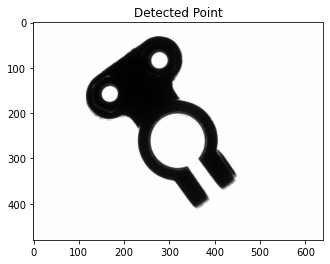

In [11]:
def fastTemplateMatch(refname, tplname, maxlevel):

    refimg = cv.imread(refname, 0)
    tplimg = cv.imread(tplname, 0)
    w, h = tplimg.shape[::-1]
    ## Call fastTemplateMatchInPyramid()
    print('input shape: ', refimg.shape)
    print('template image shape: ', tplimg.shape)
    ## Call fastTemplateMatchInPyramid()
    start_time = time.time()
    results = fastTemplateMatchPyramid0(refimg, tplimg, maxleval)
    end_time = time.time()
    print("--- %s seconds ---" % (end_time - start_time))
    print(len(results))
    threshold = 0.99
    for result, goc in results:
        minval, maxval, minloc, maxloc = cv.minMaxLoc(result)
        tpl_new = rotation(tplimg, goc)
        Wt, Ht = tpl_new.shape[::-1]
        anglerad = radians(goc)  
        result8u = cv.inRange(result, 0.8, 1)
        contours = cv.findContours(result8u, cv.RETR_EXTERNAL,  cv.CHAIN_APPROX_NONE)[-2]
        for cnt in contours:
            x, y, ww, hh = cv.boundingRect(cnt)
            minval, maxval, minloc, maxloc = cv.minMaxLoc(result[y:y+hh, x:x+ww])
            if maxval > threshold:
                deltaX, deltaY = Subpixel(result[y:y+hh+1, x:x+ww+1], maxloc[0], maxloc[1])
                pt = (maxloc[0]+x, maxloc[1]+y)    
                print('goc pt maxval:', goc, pt, maxval)
                print('goc pt maxval:', goc, (pt[0]+deltaX, pt[1]+deltaY), maxval)
                print("center:", x+w*cos(anglerad)/2, y+h*cos(anglerad)/2)
                recangleX(refimg, w, h, Wt, Ht, anglerad, pt)
    
    plt.imshow(refimg,cmap = 'gray')
    plt.title('Detected Point')
    plt.show()

if __name__ == '__main__':
    
    refname = "BAT0001.PNG"
    tplname = "BAT.PNG"
#     refname = "./messi_4.jpg"
# #     refname = "./m.jpg"
#     tplname = "./messi_face_template.jpg"
#     tplname = "./1.jpg"
#     tplname = "./messi_tpl.jpg"
#     refname = "lion.jpg"
#     tplname = "duoi.jpg"
#     refname = "img1_300.jpg"
#     tplname = "tpl1.jpg"
#     refname = "./Images/circlips_13.tif"
#     tplname = "./Images/circlips01.tif"
    maxleval = 4
    
    ## call the function
    fastTemplateMatch(refname, tplname, maxleval)
    

In [12]:
def fastTemplateMatchPyramid(src_refimg, src_tplimg, maxlevel):

    ## Build image pyramid
    refimgs = buildPyramid(src_refimg, maxlevel)
    tplimgs = buildPyramid(src_tplimg, maxlevel)

    ## Do template match
    step = 0
    results = []
    threshold = 0.95
    for idx in range(0, maxlevel+1):
        print('Level', idx)
#         print("threshold:", threshold)
        st = time.time()
        refimg = refimgs[idx]
        tplimg = tplimgs[idx]
        W, H = refimg.shape[::-1]
        Wt, Ht = tplimg.shape[::-1]
        step_save = step
        step = int(sqrt(2)/((sqrt(Ht**2+Wt**2))*pi)*360*10)
        print("Step:", step)
        masktpl = np.uint8(np.ones((Ht, Wt)))
        if idx == 0:
            for angles in range(0, 3600, step):
                angle = angles/10
                tplimg_new = rotation(tplimg, angle)
                anglerad = radians(angle)
                masktpl_new = rotation(masktpl, angle)
                result = cv.matchTemplate(refimg, tplimg_new, cv.TM_CCORR_NORMED, mask = masktpl_new)
                minval, maxval, minloc, maxloc = cv.minMaxLoc(result)
                if maxval > threshold:
#                     print(angle, maxval)
                    T, threshed = cv.threshold(result, threshold, 1., cv.THRESH_TOZERO)
                    results.append([threshed, angle])
                
        else:
            KETQUA = []
            k = step_save
            check = set([])
            for threshed, goc in results:
                mask = cv.pyrUp(threshed)
                mask8u = cv.inRange(mask, 0.95, 1)
                contours = cv.findContours(mask8u, cv.RETR_EXTERNAL,  cv.CHAIN_APPROX_NONE)[-2]
                m = 0
                res = None
                goc_res = 0
                start = int(goc * 10 - k) if goc * 10 - k > 0 else 0
                end = int(goc * 10 + k) + 1 if int(goc * 10 + k) + 1 < 3600 else 3600
                for angles in range(start, end, step):
                    angle = angles/10
                    tplimg_new = rotation(tplimg, angle)
                    tW, tH = tplimg_new.shape[::-1]
                    dX = W - tW + 1
                    dY = H - tH + 1
                    result = np.zeros([dY, dX])
                    anglerad = radians(angle)
                    masktpl_new = rotation(masktpl, angle)
                    for cnt in contours:
                        x, y, w, h = cv.boundingRect(cnt)
                        src = refimg[y-2:y+h+tH+2, x-2:x+w+tW+2]
                        if src.shape[0] < tH or src.shape[1] < tW:
                            continue
                        result[y-2:y+h+3, x-2:x+w+3] = cv.matchTemplate(src, tplimg_new, cv.TM_CCORR_NORMED, mask = masktpl_new)
                    minval, maxval, minloc, maxloc = cv.minMaxLoc(result)
                    if maxval > m:
                        m = maxval
                        res = result
                        goc_res = angle
                T, thresh = cv.threshold(res, threshold, 1., cv.THRESH_TOZERO)
                if m > threshold:
                    if goc_res not in check:
                        KETQUA.append([thresh, goc_res])
                        check.add(goc_res)
            results = KETQUA
        end = time.time()
        print("time:", end-st)
        print("-------------------")
            
    return results

input shape:  (1924, 5128)
template image shape:  (774, 561)
Level 0
Step: 52
time: 0.026927709579467773
-------------------
Level 1
Step: 26
time: 0.05707812309265137
-------------------
Level 2
Step: 13
time: 0.0669853687286377
-------------------
Level 3
Step: 6
time: 0.3295300006866455
-------------------
Level 4
Step: 3
time: 1.5137345790863037
-------------------
Level 5
Step: 1
time: 8.558970212936401
-------------------
--- 10.56918478012085 seconds ---
goc pt maxval: 0.0 (1353, 131) 0.9997750520706177
goc pt maxval: 0.0 (1352.9992843023651, 131.0009764531738) 0.9997750520706177
center: 1633 518
goc pt maxval: 0.0 (277, 131) 0.9995396733283997
goc pt maxval: 0.0 (276.9996272242288, 131.0011156810479) 0.9995396733283997
center: 557 518
goc pt maxval: 270.0 (4230, 1122) 0.9997325539588928
goc pt maxval: 270.0 (4230.0008539196115, 1122.0006162372306) 0.9997325539588928
center: 4617 1402
goc pt maxval: 316.7 (2604, 63) 0.9992221593856812
goc pt maxval: 316.7 (2604.3701472556895, 62

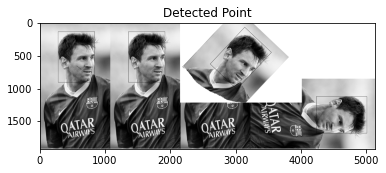

In [13]:
def fastTemplateMatch(refname, tplname, maxleval):

    refimg = cv.imread(refname, 0)
    tplimg = cv.imread(tplname, 0)
    w, h = tplimg.shape[::-1]
    print('input shape: ', refimg.shape)
    print('template image shape: ', tplimg.shape)
    ## Call fastTemplateMatchInPyramid()
    start_time = time.time()
    results = fastTemplateMatchPyramid(refimg, tplimg, maxleval)
    end_time = time.time()
    print("--- %s seconds ---" % (end_time - start_time))
    threshold = 0.999
    for result, goc in results:
        minval, maxval, minloc, maxloc = cv.minMaxLoc(result)
        tpl_new = rotation(tplimg, goc)
        tW, tH = tpl_new.shape[::-1]
        anglerad = radians(goc)  
        result8u = cv.inRange(result, 0.95, 1)
        contours = cv.findContours(result8u, cv.RETR_EXTERNAL,  cv.CHAIN_APPROX_NONE)[-2]
        for cnt in contours:
            x, y, ww, hh = cv.boundingRect(cnt)
            minval, maxval, minloc, maxloc = cv.minMaxLoc(result[y:y+hh, x:x+ww])
            if maxval > threshold:
                topleft = (maxloc[0]+x, maxloc[1]+y)           
                deltaX, deltaY = Subpixel(result, topleft[0], topleft[1])
                x, y = getValSubpixel(topleft[0]+deltaX, topleft[1]+deltaY)   
                print('goc pt maxval:', goc, topleft, maxval)
                print('goc pt maxval:', goc, (x+deltaX, y+deltaY), maxval)
                print("center:", x + tW//2, y+tH//2)
                recangleX(refimg, w, h, tW, tH, anglerad, (x, y))
    
    plt.imshow(refimg,cmap = 'gray')
    plt.title('Detected Point')
    plt.show()

if __name__ == '__main__':
    
#     refname = "BAT0001.PNG"
#     tplname = "2.PNG"
    refname = "./messi_4.jpg"
#     refname = "./m.jpg"
#     tplname = '1.jpg'
    tplname = "./messi_face_template.jpg"
#     tplname = "./messi_nose_template.jpg"
#     refname = "lion.jpg"
#     tplname = "duoi.jpg"
#     refname = "img1.jpg"
#     tplname = "tpl1.jpg"
    maxleval = 5
    
    ## call the function
    fastTemplateMatch(refname, tplname, maxleval)
    

input shape:  (1024, 1280)
template image shape:  (208, 272)
Level 0
step: 75
-------------------
Level 1
step: 37
--- 352.5 0.9926850199699402
--- 356.2 0.9894886016845703
--- 359.9 0.98459392786026
--- 3.6 0.9836187362670898
--- 7.3 0.981394350528717
--- 0.0 0.9845226407051086
--- 3.7 0.9837042093276978
--- 7.4 0.9817962050437927
--- 11.1 0.9783604741096497
--- 14.8 0.981231689453125
--- 7.5 0.9816218018531799
--- 11.2 0.9785884618759155
--- 14.9 0.9811409711837769
--- 18.6 0.9772326946258545
--- 22.3 0.9794430136680603
--- 15.0 0.9809997081756592
--- 18.7 0.9772142171859741
--- 22.4 0.979280948638916
--- 26.1 0.9802342653274536
--- 29.8 0.9761223196983337
--- 22.5 0.9789189696311951
--- 26.2 0.9802849888801575
--- 29.9 0.9763185381889343
--- 33.6 0.9765130877494812
--- 37.3 0.9725953936576843
--- 30.0 0.9765844345092773
--- 33.7 0.976517915725708
--- 37.4 0.9727143049240112
--- 41.1 0.9711011052131653
--- 44.8 0.9706209301948547
--- 37.5 0.9725921750068665
--- 41.2 0.971015572547912

--- 242.5 0.9974111318588257
--- 243.4 0.9964508414268494
--- 239.9 0.9957048296928406
--- 240.8 0.9963685274124146
--- 241.7 0.9974614977836609
--- 242.6 0.9979846477508545
--- 243.5 0.9962823390960693
--- 242.0 0.9974565505981445
--- 242.9 0.9975961446762085
--- 243.8 0.9954400658607483
--- 244.7 0.9936978816986084
--- 245.6 0.990935206413269
--- 344.7 0.9895771741867065
--- 345.6 0.9928559064865112
--- 346.5 0.9947265982627869
--- 347.4 0.9974053502082825
--- 348.3 0.9982028007507324
--- 346.8 0.995335042476654
--- 347.7 0.9970496296882629
--- 348.6 0.9979286193847656
--- 349.5 0.9978676438331604
--- 350.4 0.9958149790763855
--- 346.9 0.9955337643623352
--- 347.8 0.9968857169151306
--- 348.7 0.9979104995727539
--- 349.6 0.9978611469268799
--- 350.5 0.9955040812492371
-------------------
Level 4
step: 4
--- 347.9 0.9978881478309631
--- 348.0 0.9980101585388184
--- 348.1 0.9980476498603821
--- 348.2 0.9979114532470703
--- 348.3 0.9979877471923828
--- 348.4 0.9980694055557251
--- 348.5

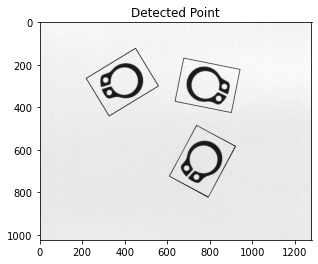

In [15]:
import cv2 as cv
import numpy as np
import time
from matplotlib import pyplot as plt
from math import radians,sin,cos,pi, sqrt

def roundUD(x):
    if x - int(x) >= 0.5:
        return int(x)+1
    return int(x)

def Subpixel(result, x, y):
    ScanRight = x+1
    ScanLeft = x-1
    ScanUp = y-1
    ScanDown = y+1
    
    deltaX = (result[y, ScanLeft]-result[y, ScanRight])/(2*result[y, ScanLeft] - 4*result[y, x] + 2*result[y, ScanRight])
    deltaY = (result[ScanDown, x]-result[ScanUp, x])/(2*result[ScanDown, x] - 4*result[y, x] + 2*result[ScanUp, x])
    
    return deltaX, deltaY
def getValSubpixel(x, y):
    a = roundUD(x)
    b = roundUD(y)
    return a, b

def rotation(image, angleInDegrees):
    h, w = image.shape[:2]
    img_c = (w/2, h/2)

    rot = cv.getRotationMatrix2D(img_c, angleInDegrees, 1)
    rad = radians(angleInDegrees)
    si = sin(rad)
    co = cos(rad)
    b_w = int((h * abs(si)) + (w * abs(co)))
    b_h = int((h * abs(co)) + (w * abs(si)))

    rot[0, 2] += ((b_w / 2) - img_c[0])
    rot[1, 2] += ((b_h / 2) - img_c[1])

    outImg = cv.warpAffine(image, rot, (b_w, b_h), flags=cv.INTER_LINEAR)
    return outImg

def recangleX(refimg,W,H, Wt,Ht, anglerad, pt):

    point1 = (-W // 2, -H // 2)
    point2 = (W // 2, -H // 2)
    point3 = (W // 2, H // 2)
    point4 = (-W // 2, H // 2)
    
    point1 = (int(point1[0] * cos(2 * pi - anglerad) - point1[1] * sin(2 * pi - anglerad)),
              int(point1[0] * sin(2 * pi - anglerad) + point1[1] * cos(2 * pi - anglerad)))
    point2 = (int(point2[0] * cos(2 * pi - anglerad) - point2[1] * sin(2 * pi - anglerad)),
              int(point2[0] * sin(2 * pi - anglerad) + point2[1] * cos(2 * pi - anglerad)))
    point3 = (int(point3[0] * cos(2 * pi - anglerad) - point3[1] * sin(2 * pi - anglerad)),
              int(point3[0] * sin(2 * pi - anglerad) + point3[1] * cos(2 * pi - anglerad)))
    point4 = (int(point4[0] * cos(2 * pi - anglerad) - point4[1] * sin(2 * pi - anglerad)),
              int(point4[0] * sin(2 * pi - anglerad) + point4[1] * cos(2 * pi - anglerad)))

    point1 = (point1[0] + pt[0] + Wt // 2, point1[1] + pt[1] + Ht // 2)
    point2 = (point2[0] + pt[0] + Wt // 2, point2[1] + pt[1] + Ht // 2)
    point3 = (point3[0] + pt[0] + Wt // 2, point3[1] + pt[1] + Ht // 2)
    point4 = (point4[0] + pt[0] + Wt // 2, point4[1] + pt[1] + Ht // 2)
    cv.line(refimg, point1, point2, (0, 255, 0), 2)
    cv.line(refimg, point2, point3, (0, 255, 0), 2)
    cv.line(refimg, point3, point4, (0, 255, 0), 2)
    cv.line(refimg, point4, point1, (0, 255, 0), 2)

def buildPyramid(image, maxleval):
    """Build image pyramid for level [0,...,maxlevel]
    """
    imgpyr = [image]
    aux = image
    for i in range(0,maxleval):
        w, h = aux.shape[::-1]
        aux = cv.pyrDown(aux)
        imgpyr.append(aux)

    imgpyr.reverse()
    return imgpyr


def fastTemplateMatchPyramid0(src_refimg, src_tplimg, maxlevel):

    ## Build image pyramid
    refimgs = buildPyramid(src_refimg, maxlevel)
    tplimgs = buildPyramid(src_tplimg, maxlevel)

    ## Do template match
    step = 0
    results = []
    threshold = 0.97
    for idx in range(0, maxlevel+1):
        print('Level', idx)
#         print("threshold:", threshold)
        st = time.time()
        refimg = refimgs[idx]
        tplimg = tplimgs[idx]
        W, H = refimg.shape[::-1]
        Wt, Ht = tplimg.shape[::-1]
        step_save = step
        step = int(sqrt(2)/((sqrt(Ht**2+Wt**2))*pi)*360*10)
        print("step:", step)
        masktpl = np.uint8(np.ones((Ht, Wt)))
        if idx == 0:
            for angles in range(0, 3600, step):
                angle = angles/10
                tplimg_new = rotation(tplimg, angle)
                anglerad = radians(angle)
                masktpl_new = rotation(masktpl, angle)
                result = cv.matchTemplate(refimg, tplimg_new, cv.TM_CCORR_NORMED, mask = masktpl_new)
                minval, maxval, minloc, maxloc = cv.minMaxLoc(result)
                
                
                if maxval > threshold:
#                     print(angle, maxval)
                    T, threshed = cv.threshold(result, threshold, 1., cv.THRESH_TOZERO)
                    results.append([threshed, angle])
                
        else:
            KETQUA = []
            k = step_save
            check = set([])
            for threshed, goc in results:
                mask = cv.pyrUp(threshed)
                mask8u = cv.inRange(mask, 0.7, 1)
#                 plt.imshow(mask8u,cmap='gray')
#                 plt.show()
                contours = cv.findContours(mask8u, cv.RETR_EXTERNAL,  cv.CHAIN_APPROX_NONE)[-2]
                m = 0
                res = None
                goc_res = 0
                start = int(goc * 10 - k) #if goc * 10 - k >= 0 else 0
                end = int(goc * 10 + k) + 1 #if int(goc * 10 + k) + 1 < 3600 else 3600
                if idx == maxlevel:
                    step = 1
                for angles in range(start, end, step):
                    angle = angles/10
                    if angle < 0:
                        angle += 360
                    if angle >= 360:
                        angle -= 360
                    tplimg_new = rotation(tplimg, angle)
                    tW, tH = tplimg_new.shape[::-1]
                    dX = W - tW + 1
                    dY = H - tH + 1
                    result = np.zeros([dY, dX])
                    anglerad = radians(angle)
                    masktpl_new = rotation(masktpl, angle)
                    for cnt in contours:
                        x, y, w, h = cv.boundingRect(cnt)
                        src = refimg[y-2:y+h+tH+2, x-2:x+w+tW+2]
                        if src.shape[0] < tH or src.shape[1] < tW:
                            continue
                        result[y-2:y+h+3, x-2:x+w+3] = cv.matchTemplate(src, tplimg_new, cv.TM_CCORR_NORMED, mask = masktpl_new)
                    minval, maxval, minloc, maxloc = cv.minMaxLoc(result)
                    print("---", angle, maxval)
                    if maxval > m:
                        m = maxval
                        res = result
                        goc_res = angle
                T, thresh = cv.threshold(res, threshold, 1., cv.THRESH_TOZERO)
                if m > 0.99:
#                     print(goc_res)
                    if goc_res not in check:
                        KETQUA.append([thresh, goc_res])
                        check.add(goc_res)
            results = KETQUA
        end = time.time()
#         print("time:", end-st)
        print("-------------------")
            
    return results
def fastTemplateMatch(refname, tplname, maxlevel):

    refimg = cv.imread(refname, 0)
    tplimg = cv.imread(tplname, 0)
    w, h = tplimg.shape[::-1]
    ## Call fastTemplateMatchInPyramid()
    print('input shape: ', refimg.shape)
    print('template image shape: ', tplimg.shape)
    ## Call fastTemplateMatchInPyramid()
    start_time = time.time()
    results = fastTemplateMatchPyramid0(refimg, tplimg, maxleval)
    end_time = time.time()
    print("--- %s seconds ---" % (end_time - start_time))
    print(len(results))
    threshold = 0.995
    for result, goc in results:
        minval, maxval, minloc, maxloc = cv.minMaxLoc(result)
        tpl_new = rotation(tplimg, goc)
        Wt, Ht = tpl_new.shape[::-1]
        anglerad = radians(goc)  
        result8u = cv.inRange(result, 0.99, 1)
        contours = cv.findContours(result8u, cv.RETR_EXTERNAL,  cv.CHAIN_APPROX_NONE)[-2]
        for cnt in contours:
            x, y, ww, hh = cv.boundingRect(cnt)
            minval, maxval, minloc, maxloc = cv.minMaxLoc(result[y:y+hh, x:x+ww])
            if maxval > threshold:
                deltaX, deltaY = Subpixel(result[y:y+hh+1, x:x+ww+1], maxloc[0], maxloc[1])
                pt = (maxloc[0]+x, maxloc[1]+y)    
                print('goc pt maxval:', goc, pt, maxval)
                print('goc pt maxval:', goc, (pt[0]+deltaX, pt[1]+deltaY), maxval)
                print("center:", x+w*cos(anglerad)/2, y+h*cos(anglerad)/2)
                recangleX(refimg, w, h, Wt, Ht, anglerad, pt)
    
    plt.imshow(refimg,cmap = 'gray')
    plt.title('Detected Point')
    plt.show()


if __name__ == '__main__':
    
#     refname = "BAT0001.PNG"
#     tplname = "BAT.PNG"
    refname = "messi_4.jpg"
    tplname = "messi_face_template.jpg"
#     refname = "lion.jpg"
#     tplname = "duoi.jpg"
#     refname = "img1_300.jpg"
#     tplname = "tpl1.jpg"
    refname = "./Images/circlips_13.tif"
    tplname = "./Images/circlips01.tif"
    maxleval = 4
    
    ## call the function
    fastTemplateMatch(refname, tplname, maxleval)